In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')
test_path = "/content/gdrive/MyDrive/300WLPA_2dLFPW.zip"
train_path = "/content/gdrive/MyDrive/train_data/dataset_1000.zip"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!unzip "/content/gdrive/MyDrive/300WLPA_2dLFPW.zip"

Archive:  /content/gdrive/MyDrive/300WLPA_2dLFPW.zip
warning [/content/gdrive/MyDrive/300WLPA_2dLFPW.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [/content/gdrive/MyDrive/300WLPA_2dLFPW.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
replace 300WLPA_2d/images/LFPW/LFPW_image_train_0001_0/LFPW_image_train_0001_0_-0.418_0.122_-0.005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 300WLPA_2d/images/LFPW/LFPW_image_train_0001_0/LFPW_image_train_0001_0_-0.505_0.122_-0.005.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
!unzip "/content/gdrive/MyDrive/train_data/dataset_1000.zip"

Archive:  /content/gdrive/MyDrive/train_data/dataset_1000.zip
replace 000000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
#install weights and biases for data logging
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Currently logged in as: alexmountain. Use `wandb login --relogin` to force relogin


In [6]:
#time all processes to measure network efficiency
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 556 µs (started: 2022-11-19 18:20:55 +00:00)


**Imports**

In [7]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pretrainedmodels
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as one
import matplotlib
from tqdm import tqdm
from torchvision import transforms
import albumentations
import wandb

time: 4.47 s (started: 2022-11-19 18:20:55 +00:00)


**Config**

In [8]:
#paths
TEST_ROOT_PATH = '/content/300WLPA_2d'
TRAIN_ROOT_PATH = '/content'
OUTPUT_PATH = 'outputs'
# hyperparameters
BATCH_SIZE = 32 #could try smaller batch size. If model is still improving in last epoch this can be increased.
LR = 1e-3
EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train/test split
TEST_SPLIT = 0.1 #for testing without training we want to test on most of the data
# show dataset keypoint plot
SHOW_DATASET_PLOT = True
RANDOM_SEED=42

time: 40.4 ms (started: 2022-11-19 18:21:00 +00:00)


**Utility**

In [9]:
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    #plt.savefig(f"{OUTPUT_PATH}/val_epoch_{epoch}.png")
    plt.show()
    # plt.close()

def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact correct and the faces align with the keypoint features. The plot 
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    plt.show()
    plt.close()
  

time: 3.35 ms (started: 2022-11-19 18:21:00 +00:00)


**Dataset Class**

In [10]:
def train_test_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples       

class FaceKeypointTrainDataset(Dataset):
    def __init__(self, samples, path):
        self.data = samples
        self.path = path
        self.resize = 224
        #normalization required for pretrained pytorch networks
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def __len__(self):
        return len(self.data)

    def get_keypoints(self, file_name):
        #remove file extension from file_name
        idx = [idx for idx, x in enumerate(file_name) if x == '.']
        file_name = file_name[:idx[0]]
        #get name of keypoint file
        file_name = file_name + "_ldmks.txt"
        #fetch file and extract keypoints as list of tuples
        keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
        keypoints = np.array(keypoints, dtype='float32')
        return keypoints
    
    def __getitem__(self, index):
        image = cv2.imread(f"{self.path}/{self.data[index]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w, channel = image.shape
        # resize the image into `resize` defined above
        image = cv2.resize(image, (self.resize, self.resize))
        # again reshape to add grayscale channel format
        image = image / 255.0
        # transpose for getting the channel size to index 0
        image = np.transpose(image, (2, 0, 1))
        image = torch.tensor(image, dtype=torch.float)
        image = self.normalize(image)
        # get the keypoints
        keypoints = self.get_keypoints(self.data[index])
        # reshape the keypoints
        keypoints = keypoints.reshape(-1, 2)
        # rescale keypoints according to image resize
        keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
        return {
            'image': image,
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

class FaceKeypointTestDataset(Dataset):
    def __init__(self, path):
      names = []
      for i in range(0,139):
        names.append(str(i))
      dataframe = pd.read_csv(filepath_or_buffer = path + "/keypoints/300WLPA_LFPW.txt", sep=" ", names=names, header=None)
      self.data = dataframe
      self.path = path
      self.resize = 224
      #normalization required for pretrained pytorch networks
      self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

    def __len__(self):
        return len(self.data)

    def get_300WLPA_item(self, name):
      pathname = self.path + "/images/" + name
      image = cv2.imread(pathname)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      orig_h, orig_w, channel = image.shape
      # resize the image into `resize` defined above
      image = cv2.resize(image, (self.resize, self.resize))
      # again reshape to add grayscale channel format
      image = image / 255.0
      # transpose for getting the channel size to index 0
      image = np.transpose(image, (2, 0, 1))
      image = torch.tensor(image, dtype=torch.float)
      image = self.normalize(image)
      # get the keypoints
      keypoints = self.data.loc[name].to_numpy()
      keypoints = keypoints[0:136] #last 3 values are not point coords (2 of them are negative)
      # reshape the keypoints
      keypoints = keypoints.reshape(68, 2)
      # rescale keypoints according to image resize
      keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
      return image, torch.tensor(keypoints,dtype=torch.float)

    def get_300WLPA_Data(self):
      #get image names and keypoint data all in a single dataframe
      #randomly get 1000 image names from column 0 of the dataframe.
      image_names = self.data.index.to_numpy()
      np.random.seed(RANDOM_SEED)
      np.random.shuffle(image_names)
      image_names = image_names[0:1000]

      return image_names

time: 7.39 ms (started: 2022-11-19 18:21:00 +00:00)


**Setup Data**

Training sample instances: 900
Validation sample instances: 100


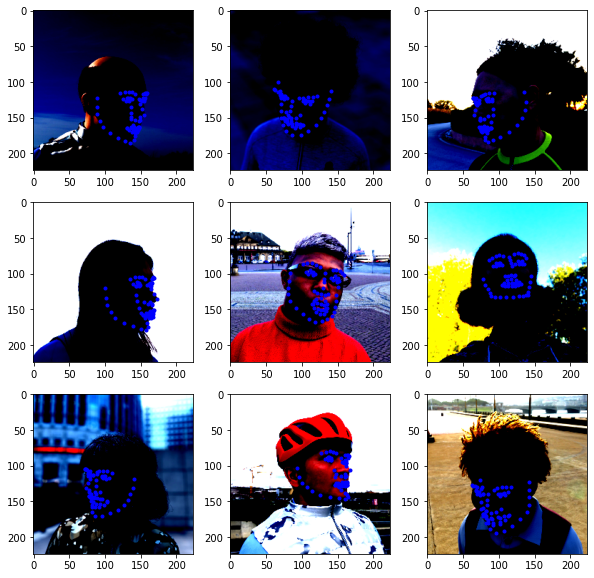

time: 2.1 s (started: 2022-11-19 18:21:00 +00:00)


In [11]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"{TRAIN_ROOT_PATH}", TEST_SPLIT)
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointTrainDataset(training_samples, f"{TRAIN_ROOT_PATH}")
valid_data = FaceKeypointTrainDataset(valid_samples, f"{TRAIN_ROOT_PATH}")
# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(valid_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

# whether to show dataset keypoint plots
if SHOW_DATASET_PLOT:
    dataset_keypoints_plot(valid_data)


**Model Class**

In [12]:
class FaceKeypointResNet50(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(FaceKeypointResNet50, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(2048, 140)

    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0

time: 5.02 ms (started: 2022-11-19 18:21:02 +00:00)


**Training**

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training intermediate layer parameters...


NME,▁
epoch,▁
train_loss,▁
val_loss,▁
NME,3.27843
epoch,1
train_loss,97.77084
val_loss,77.15812


Epoch 1 of 30
Training


29it [00:38,  1.31s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:1
i:0


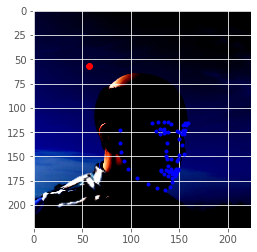

 67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

epochs:1
i:1


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

epochs:1
i:2


4it [00:03,  1.01it/s]

epochs:1
i:3
Train Loss: 97.4505
Val Loss: 64.4574
NME: 2.8399


Epoch 2 of 30
Training


29it [00:38,  1.31s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:2
i:0


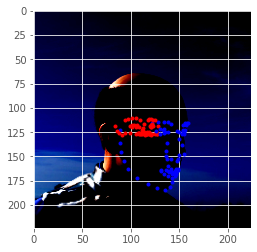

 67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

epochs:2
i:1


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

epochs:2
i:2


4it [00:03,  1.02it/s]

epochs:2
i:3
Train Loss: 38.3293
Val Loss: 17.9975
NME: 0.9370


Epoch 3 of 30
Training


29it [00:39,  1.36s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:3
i:0


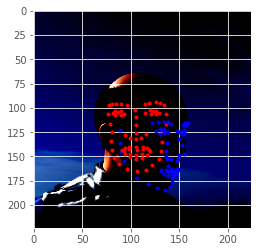

 67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

epochs:3
i:1


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]

epochs:3
i:2


4it [00:05,  1.41s/it]

epochs:3
i:3
Train Loss: 14.1427
Val Loss: 14.9788
NME: 0.7348


Epoch 4 of 30
Training


29it [00:41,  1.42s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:4
i:0


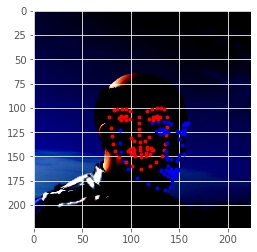

 67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

epochs:4
i:1


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

epochs:4
i:2


4it [00:03,  1.03it/s]

epochs:4
i:3
Train Loss: 13.3071
Val Loss: 13.4099
NME: 0.6800


Epoch 5 of 30
Training


29it [00:38,  1.31s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:5
i:0


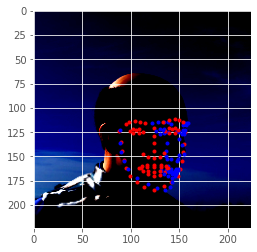

 67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

epochs:5
i:1


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

epochs:5
i:2


4it [00:03,  1.03it/s]

epochs:5
i:3
Train Loss: 12.3411
Val Loss: 12.4132
NME: 0.7237


Epoch 6 of 30
Training


29it [00:38,  1.34s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:6
i:0


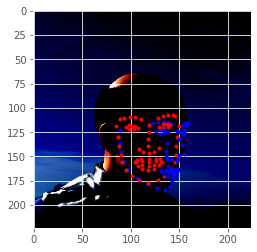

 67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

epochs:6
i:1


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

epochs:6
i:2


4it [00:04,  1.02s/it]

epochs:6
i:3
Train Loss: 12.0618
Val Loss: 12.1380
NME: 0.6466


Epoch 7 of 30
Training


29it [00:39,  1.38s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:7
i:0


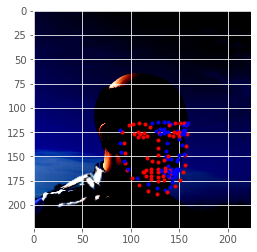

 67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

epochs:7
i:1


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

epochs:7
i:2


4it [00:03,  1.02it/s]

epochs:7
i:3
Train Loss: 11.6110
Val Loss: 11.9545
NME: 0.6894


Epoch 8 of 30
Training


29it [00:39,  1.37s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:8
i:0


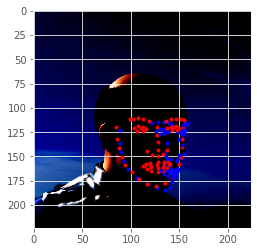

 67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

epochs:8
i:1


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

epochs:8
i:2


4it [00:03,  1.01it/s]

epochs:8
i:3
Train Loss: 11.3058
Val Loss: 11.4808
NME: 0.6648


Epoch 9 of 30
Training


29it [00:41,  1.42s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:9
i:0


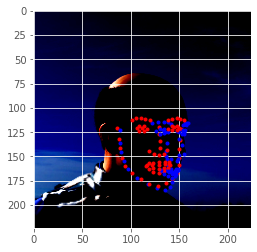

 67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

epochs:9
i:1


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]

epochs:9
i:2


4it [00:05,  1.28s/it]

epochs:9
i:3
Train Loss: 9.6692
Val Loss: 8.8976
NME: 0.4838


Epoch 10 of 30
Training


29it [00:40,  1.40s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:10
i:0


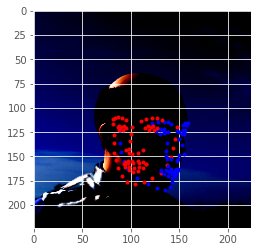

 67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]

epochs:10
i:1


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]

epochs:10
i:2


4it [00:04,  1.03s/it]


epochs:10
i:3
Train Loss: 7.0682
Val Loss: 10.5006
NME: 0.5084
Epoch 11 of 30
Training


29it [00:38,  1.34s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:11
i:0


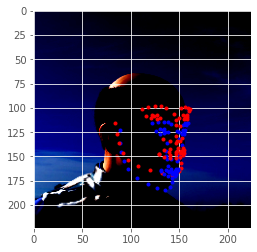

 67%|██████▋   | 2/3 [00:06<00:03,  3.15s/it]

epochs:11
i:1


100%|██████████| 3/3 [00:07<00:00,  2.16s/it]

epochs:11
i:2


4it [00:08,  2.01s/it]


epochs:11
i:3
Train Loss: 6.4440
Val Loss: 11.0043
NME: 1.0993
Epoch 12 of 30
Training


29it [00:40,  1.40s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:12
i:0


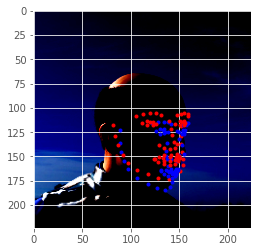

 67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

epochs:12
i:1


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

epochs:12
i:2


4it [00:04,  1.03s/it]

epochs:12
i:3
Train Loss: 6.2987
Val Loss: 5.7690
NME: 0.3202


Epoch 13 of 30
Training


29it [00:38,  1.32s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:13
i:0


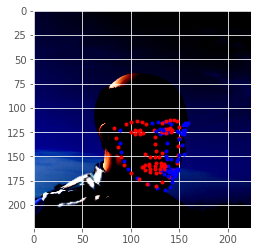

 67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

epochs:13
i:1


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

epochs:13
i:2


4it [00:03,  1.01it/s]


epochs:13
i:3
Train Loss: 5.8502
Val Loss: 6.1947
NME: 0.3312
Epoch 14 of 30
Training


29it [00:37,  1.31s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:14
i:0


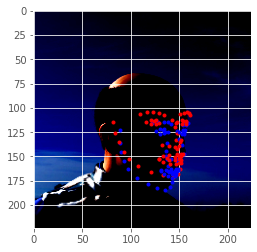

 67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

epochs:14
i:1


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

epochs:14
i:2


4it [00:04,  1.02s/it]

epochs:14
i:3
Train Loss: 5.3575
Val Loss: 5.5756
NME: 0.3078


Epoch 15 of 30
Training


29it [00:38,  1.31s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:15
i:0


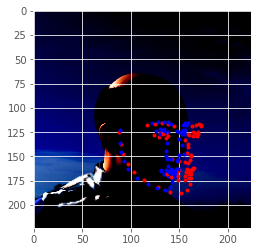

 67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

epochs:15
i:1


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

epochs:15
i:2


4it [00:03,  1.02it/s]


epochs:15
i:3
Train Loss: 4.9399
Val Loss: 7.3413
NME: 0.3555
Epoch 16 of 30
Training


29it [00:41,  1.42s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:16
i:0


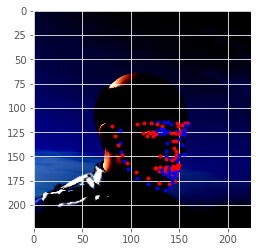

 67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

epochs:16
i:1


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

epochs:16
i:2


4it [00:03,  1.02it/s]

epochs:16
i:3
Train Loss: 5.0202
Val Loss: 4.9649
NME: 0.3119


Epoch 17 of 30
Training


29it [00:38,  1.31s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:17
i:0


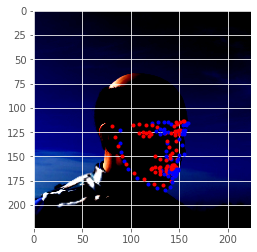

 67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

epochs:17
i:1


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

epochs:17
i:2


4it [00:03,  1.01it/s]

epochs:17
i:3
Train Loss: 4.6586
Val Loss: 4.8565
NME: 0.2886


Epoch 18 of 30
Training


29it [00:38,  1.31s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:18
i:0


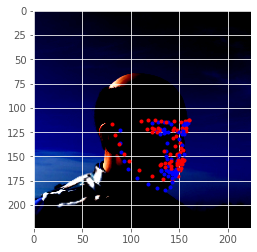

 67%|██████▋   | 2/3 [00:02<00:01,  1.18s/it]

epochs:18
i:1


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

epochs:18
i:2


4it [00:04,  1.02s/it]


epochs:18
i:3
Train Loss: 4.4058
Val Loss: 5.7825
NME: 0.3228
Epoch 19 of 30
Training


29it [00:37,  1.30s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:19
i:0


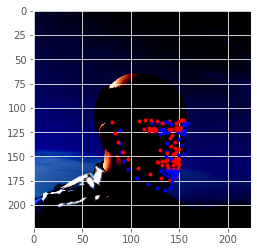

 67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

epochs:19
i:1


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

epochs:19
i:2


4it [00:03,  1.03it/s]


epochs:19
i:3
Train Loss: 4.4985
Val Loss: 8.0053
NME: 0.4905
Epoch 20 of 30
Training


29it [00:40,  1.41s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:20
i:0


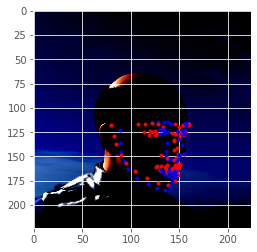

 67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

epochs:20
i:1


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

epochs:20
i:2


4it [00:03,  1.03it/s]

epochs:20
i:3
Train Loss: 4.8563
Val Loss: 4.1819
NME: 0.2206


Epoch 21 of 30
Training


29it [00:37,  1.30s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:21
i:0


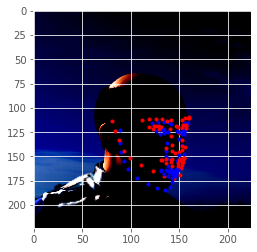

 67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

epochs:21
i:1


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

epochs:21
i:2


4it [00:03,  1.03it/s]


epochs:21
i:3
Train Loss: 4.6860
Val Loss: 5.2898
NME: 0.3154
Epoch 22 of 30
Training


29it [00:38,  1.33s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:22
i:0


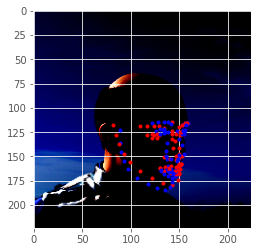

 67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

epochs:22
i:1


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]

epochs:22
i:2


4it [00:03,  1.03it/s]


epochs:22
i:3
Train Loss: 4.3177
Val Loss: 4.5020
NME: 0.2245
Epoch 23 of 30
Training


29it [00:37,  1.30s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:23
i:0


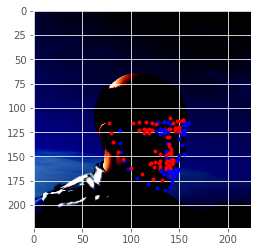

 67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]

epochs:23
i:1


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

epochs:23
i:2


4it [00:03,  1.03it/s]

epochs:23
i:3
Train Loss: 3.9882
Val Loss: 4.1291
NME: 0.2609


Epoch 24 of 30
Training


29it [00:39,  1.37s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:24
i:0


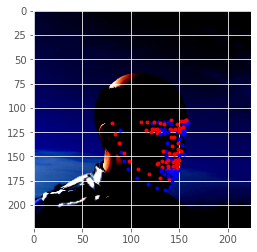

 67%|██████▋   | 2/3 [00:03<00:01,  1.58s/it]

epochs:24
i:1


100%|██████████| 3/3 [00:04<00:00,  1.31s/it]

epochs:24
i:2


4it [00:04,  1.23s/it]


epochs:24
i:3
Train Loss: 3.9104
Val Loss: 4.4305
NME: 0.2748
Epoch 25 of 30
Training


29it [00:37,  1.30s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:25
i:0


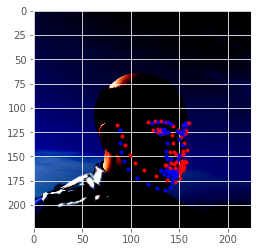

 67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

epochs:25
i:1


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

epochs:25
i:2


4it [00:04,  1.02s/it]


epochs:25
i:3
Train Loss: 3.9367
Val Loss: 5.2849
NME: 0.2952
Epoch 26 of 30
Training


29it [00:37,  1.30s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:26
i:0


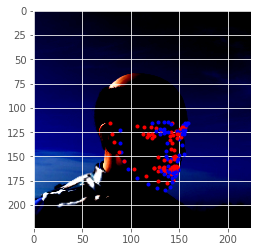

 67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

epochs:26
i:1


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

epochs:26
i:2


4it [00:03,  1.04it/s]


epochs:26
i:3
Train Loss: 3.8302
Val Loss: 4.3969
NME: 0.2325
Epoch 27 of 30
Training


29it [00:37,  1.29s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:27
i:0


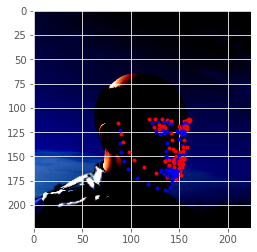

 67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]

epochs:27
i:1


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

epochs:27
i:2


4it [00:03,  1.01it/s]


epochs:27
i:3
Train Loss: 3.8003
Val Loss: 4.8033
NME: 0.2761
Epoch 28 of 30
Training


29it [00:37,  1.29s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:28
i:0


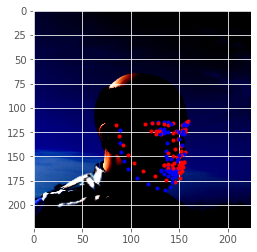

 67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]

epochs:28
i:1


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

epochs:28
i:2


4it [00:03,  1.03it/s]

epochs:28
i:3
Train Loss: 3.8981
Val Loss: 3.7231
NME: 0.2001


Epoch 29 of 30
Training


29it [00:40,  1.40s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:29
i:0


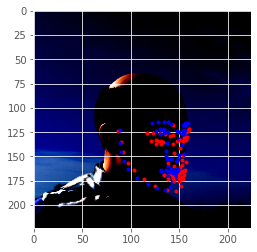

 67%|██████▋   | 2/3 [00:02<00:01,  1.10s/it]

epochs:29
i:1


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

epochs:29
i:2


4it [00:03,  1.04it/s]


epochs:29
i:3
Train Loss: 3.7975
Val Loss: 5.0755
NME: 0.2537
Epoch 30 of 30
Training


29it [00:37,  1.30s/it]


Validating


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:30
i:0


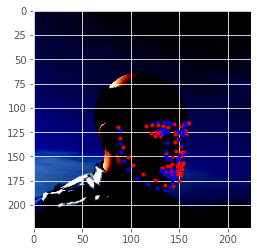

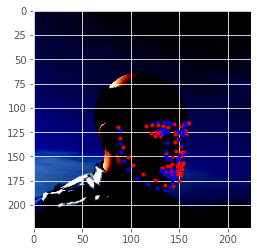

 33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:30
i:1


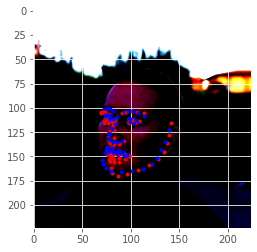

 67%|██████▋   | 2/3 [00:03<00:01,  1.50s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:30
i:2


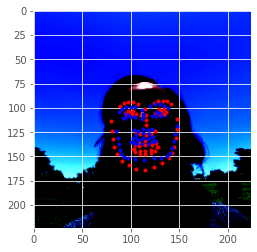

100%|██████████| 3/3 [00:04<00:00,  1.40s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epochs:30
i:3


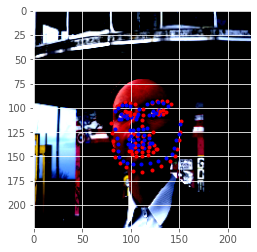

4it [00:05,  1.31s/it]


Train Loss: 3.8981
Val Loss: 3.8312
NME: 0.2017


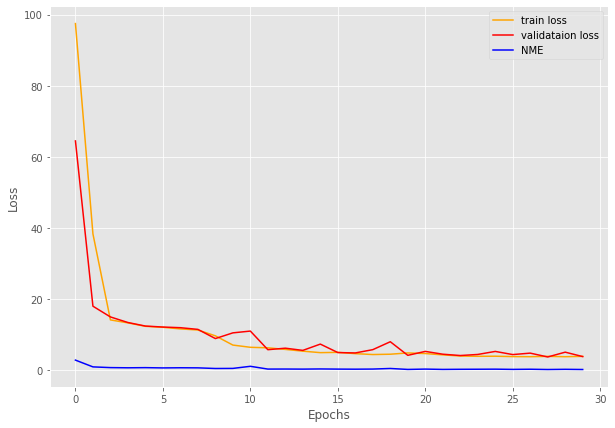

DONE TRAINING
time: 22min 2s (started: 2022-11-19 18:24:46 +00:00)


In [15]:
def compute_nme(preds, target):
    """ preds/target:: numpy array, shape is (N, L, 2)
        N: batchsize L: num of landmark 
    """
    preds = preds.cuda().detach().cpu().clone().numpy()
    target = target.cuda().detach().cpu().clone().numpy()

    preds = preds[:, 0:136]
    
    N = preds.shape[0]
    preds = np.reshape(preds, (N, 68, 2))
    L = preds.shape[1]
    L_targ = target.shape[1]

    if L_targ == 140:
      target = target[:, 0:136]
    target = np.reshape(target, (N, 68, 2))

    rmse = np.zeros(N)

    for i in range(N):
        pts_pred, pts_gt = preds[i, ], target[i, ]
        if L == 68:  # 300w
            # interocular
            interocular = np.linalg.norm(pts_gt[36, ] - pts_gt[45, ])
        else:
            raise ValueError('Number of landmarks is wrong')
        rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt,
                                        axis=1)) / (interocular * L)

    return np.mean(rmse)

matplotlib.style.use('ggplot')
#model 
#NOTE: setting pretrained=True and requires_grad=True initializes our weights with pretrained model and then updates our intermediate layers
model = FaceKeypointResNet50(pretrained=True, requires_grad=True).to(DEVICE)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# we need a loss function which is good for regression like SmmothL1Loss ...
# ... or MSELoss
criterion = nn.SmoothL1Loss() #TODO test both MSELoss and SmoothL1Loss

# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/counter
    return train_loss 

# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            nme = compute_nme(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs\
            if (epoch+1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
            if epoch+1 == EPOCHS:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
        
    valid_loss = valid_running_loss/counter
    return valid_loss, nme

# Do training and validation

wandb.init(project="resnet50_domain_gap")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}
wandb.watch(model, criterion, log="all", log_freq=1) #TODO might want to change log_freq?

best_val_loss = 1000
# Want to test without training: do validation for a small number of epochs
train_loss = []
val_loss = []
nme = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss, nme_val = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    nme.append(nme_val)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print(f'NME: {nme_val:.4f}')
    wandb.log({"epoch": (epoch+1),
               "train_loss": (train_epoch_loss),
               "val_loss": (val_epoch_loss),
               "NME": (nme_val)})
    wandb.define_metric("epoch")
    if val_epoch_loss < best_val_loss:
      best_val_loss = val_epoch_loss
      torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'sample_data/resnet50_1000.pt')


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.plot(nme, color='blue', label='NME')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(f"{OUTPUT_PATH}/loss.png")
plt.show()

print('DONE TRAINING')


**Testing Phase**

In [22]:
#Run model on test data from 300WLPA dataset and report NME

testdata = FaceKeypointTestDataset(TEST_ROOT_PATH)
dataframe = testdata.get_300WLPA_Data()
nme = []
for n in dataframe:
  image, keypoints = testdata.get_300WLPA_item(n)
  image = torch.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
  image = image.to(DEVICE)
  keypoints = torch.reshape(keypoints, (1, keypoints.shape[0], keypoints.shape[1]))
  outputs = model(image)
  nme_val = compute_nme(outputs, keypoints)
  print(nme_val)
  nme.append(nme_val)


nme = np.array(nme)
print("Average NME: " + str(np.mean(nme)))

(94579, 139)
['LFPW/LFPW_image_train_0001_0/LFPW_image_train_0001_0_-0.418_0.122_-0.005.jpg'
 'LFPW/LFPW_image_train_0001_0/LFPW_image_train_0001_0_-0.505_0.122_-0.005.jpg'
 'LFPW/LFPW_image_train_0001_0/LFPW_image_train_0001_0_-0.592_0.122_-0.005.jpg'
 ...
 'LFPW/LFPW_image_train_0871_9/LFPW_image_train_0871_9_-0.549_0.893_-0.149.jpg'
 'LFPW/LFPW_image_train_0871_9/LFPW_image_train_0871_9_-0.636_0.893_-0.149.jpg'
 'LFPW/LFPW_image_train_0871_9/LFPW_image_train_0871_9_-0.723_0.893_-0.149.jpg']
Average NME: 0.7396275095383572
time: 9min 59s (started: 2022-11-19 18:59:10 +00:00)


**Video Integration**

If this doesn't work in colab then run it locally by downloading the model after training 

(download will take a while unfortunately).

You will also require the above code that handles hyperparameter configuration and the code that defines our model class

In [ ]:
#Imports required for running video locally:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torchvision import transforms
import pretrainedmodels

In [ ]:
model = FaceKeypointResNet50(pretrained=False, requires_grad=False).to(DEVICE)
checkpoint = torch.load('sample_data/my_model_1000.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#capture the webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
if cap.isOpened()==False:
  print('Error while trying to open webcam. Please check again...')

# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# set up the save file path
save_path = "sample_data/vid_keypoint_detection.mp4"
# define codec and create VideoWriter object 
out = cv2.VideoWriter(f"{save_path}", 
                      cv2.VideoWriter_fourcc(*'mp4v'), 20, 
                      (frame_width, frame_height))
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 

while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        with torch.no_grad():
            image = frame
            image = cv2.resize(image, (224, 224))
            orig_frame = image.copy()
            orig_h, orig_w, c = orig_frame.shape
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.0
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float)
            image = norm(image)
            image = image.unsqueeze(0).to(DEVICE)
            outputs = model(image)
        outputs = outputs.cpu().detach().numpy()
        outputs = outputs.reshape(-1, 2)
        keypoints = outputs
        for p in range(keypoints.shape[0]):
            cv2.circle(orig_frame, (int(keypoints[p, 0]), int(keypoints[p, 1])),
                        1, (0, 0, 255), -1, cv2.LINE_AA)
        orig_frame = cv2.resize(orig_frame, (frame_width, frame_height))
        cv2.imshow('Facial Keypoint Frame', orig_frame)
        out.write(orig_frame)
        # press `q` to exit
        if cv2.waitKey(27) & 0xFF == ord('q'):
            break
 
    else: 
        break